In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import time
import torch.optim as optim

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.relu(x)
        return x


class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self._make_layer(16, 3)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




In [2]:
# Creating the model
model = ResNet20()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_memory_usage(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 * 1024)  # Convert to MB

def calculate_flops(model, input_size=(3, 32, 32)):
    def hook_fn(module, input, output):
        nonlocal flops
        if isinstance(module, nn.Conv2d):
            flops += 2 * output.size(1) * output.size(2) * output.size(3) * module.kernel_size[0] * module.kernel_size[1] * module.in_channels
        elif isinstance(module, nn.Linear):
            flops += 2 * output.size(1) * input[0].size(1)

    flops = 0
    hooks = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(hook_fn))

    input = torch.randn(1, *input_size)
    model(input)

    for hook in hooks:
        hook.remove()

    return flops

def measure_latency(model, device, input_size=(3, 32, 32), num_iterations=100):
    model = model.to(device)
    input = torch.randn(1, *input_size).to(device)

    # Warm-up
    for _ in range(10):
        _ = model(input)

    torch.cuda.synchronize() if device.type == 'cuda' else None

    start_time = time.time()
    for _ in range(num_iterations):
        _ = model(input)
    torch.cuda.synchronize() if device.type == 'cuda' else None

    end_time = time.time()
    return (end_time - start_time) / num_iterations

# Calculate and print statistics
model = ResNet20()
num_params = count_parameters(model)
memory_usage = calculate_memory_usage(model)
flops = calculate_flops(model)

print(f"Number of trainable parameters: {num_params}")
print(f"Minimum required on-chip memory: {memory_usage:.2f} MB")
print(f"Number of FLOPs: {flops}")

# Measure latency on CPU and GPU if available
cpu_device = torch.device('cpu')
cpu_latency = measure_latency(model, cpu_device)
print(f"CPU Latency: {cpu_latency*1000:.2f} ms")

if torch.cuda.is_available():
    gpu_device = torch.device('cuda')
    gpu_latency = measure_latency(model, gpu_device)
    print(f"GPU Latency: {gpu_latency*1000:.2f} ms")

Number of trainable parameters: 272474
Minimum required on-chip memory: 1.05 MB
Number of FLOPs: 81626368
CPU Latency: 7.20 ms
GPU Latency: 5.04 ms


In [3]:

model = ResNet20()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Trainable Parameters: {count_parameters(model)}")

# Data loading and preprocessing for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#CIFAR-10 dataset
train_set = datasets.CIFAR10(root='../../data/', train = True, transform = transform, download = True)

test_set = datasets.CIFAR10(root='../../data/', train = False, transform = transform, download = True)

# Split training set into training and validation sets (95% train, 5% validation)
train_size = int(0.95 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)





Total Trainable Parameters: 272474


100%|██████████| 170498071/170498071 [00:03<00:00, 43893264.52it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/
Files already downloaded and verified


In [4]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, val_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(val_loader.dataset)
    return accuracy

In [5]:
 # Define hyperparameter grid
learning_rates = [0.01, 0.001, 0.1]
batch_sizes = [32, 64]

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameter tuning loop
best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Create data loaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the model and optimizer
        model = model.to(device) # move model to GPU
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(6):  # Use a few epochs for demonstration
            train(model, device, train_loader, optimizer, criterion)

        # Evaluate the model on the validation set
        accuracy = evaluate(model, device, val_loader)
        print(f'Learning Rate: {lr}, Batch Size: {batch_size}, Validation Accuracy: {accuracy:.2f}%')

        # Update best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f'Best Validation Accuracy: {best_accuracy:.2f}% with Parameters: {best_params}')

Learning Rate: 0.01, Batch Size: 32, Validation Accuracy: 70.68%
Learning Rate: 0.01, Batch Size: 64, Validation Accuracy: 78.24%
Learning Rate: 0.001, Batch Size: 32, Validation Accuracy: 79.60%
Learning Rate: 0.001, Batch Size: 64, Validation Accuracy: 80.48%
Learning Rate: 0.1, Batch Size: 32, Validation Accuracy: 75.80%
Learning Rate: 0.1, Batch Size: 64, Validation Accuracy: 78.28%
Best Validation Accuracy: 80.48% with Parameters: {'learning_rate': 0.001, 'batch_size': 64}


Epoch 1/90 - Train Loss: 0.7825, Test Accuracy: 74.46%
Epoch 2/90 - Train Loss: 0.6487, Test Accuracy: 72.90%
Epoch 3/90 - Train Loss: 0.6363, Test Accuracy: 67.86%
Epoch 4/90 - Train Loss: 0.6211, Test Accuracy: 71.85%
Epoch 5/90 - Train Loss: 0.6108, Test Accuracy: 71.35%
Epoch 6/90 - Train Loss: 0.5905, Test Accuracy: 67.72%
Epoch 7/90 - Train Loss: 0.5866, Test Accuracy: 72.22%
Epoch 8/90 - Train Loss: 0.5665, Test Accuracy: 75.31%
Epoch 9/90 - Train Loss: 0.5620, Test Accuracy: 68.49%
Epoch 10/90 - Train Loss: 0.5616, Test Accuracy: 73.75%
Epoch 11/90 - Train Loss: 0.5534, Test Accuracy: 70.99%
Epoch 12/90 - Train Loss: 0.5365, Test Accuracy: 74.81%
Epoch 13/90 - Train Loss: 0.5389, Test Accuracy: 79.68%
Epoch 14/90 - Train Loss: 0.5260, Test Accuracy: 74.75%
Epoch 15/90 - Train Loss: 0.5204, Test Accuracy: 73.42%
Epoch 16/90 - Train Loss: 0.5139, Test Accuracy: 75.63%
Epoch 17/90 - Train Loss: 0.5142, Test Accuracy: 78.49%
Epoch 18/90 - Train Loss: 0.4978, Test Accuracy: 77.45%
E

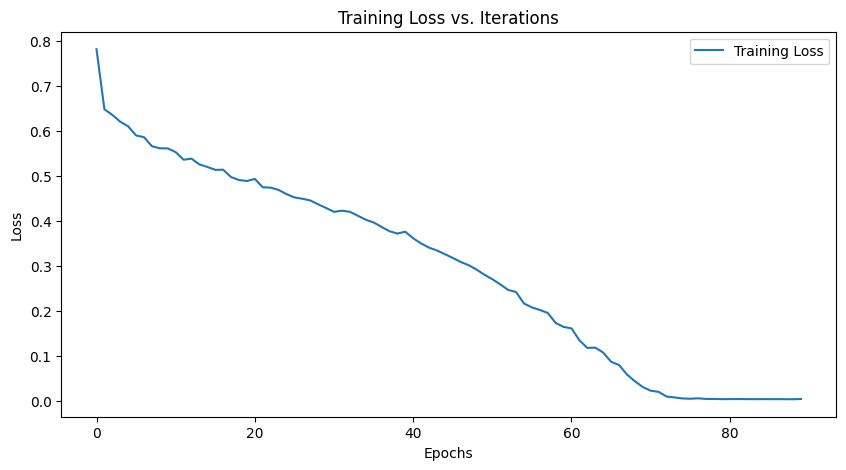

Final Test Accuracy: 87.91%


In [6]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=90)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_accuracies = []

for epoch in range(90):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100. * correct / total
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/90 - Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    scheduler.step()

# Plot the training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss vs. Iterations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

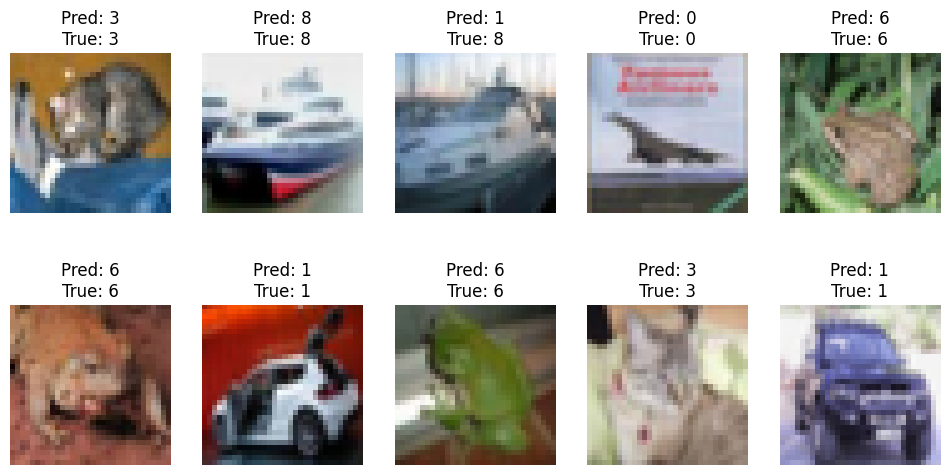

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get random images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Print images
model.eval()
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Print 10 images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i])
    plt.title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}')
    plt.axis('off')
plt.show()
